In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


In [9]:
df0 = pd.read_csv("../data/clean_data.csv", parse_dates=[1])
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10909889 entries, 0 to 10909888
Data columns (total 13 columns):
Unnamed: 0             int64
FL_DATE                datetime64[ns]
OP_UNIQUE_CARRIER      object
ORIGIN_AIRPORT_ID      int64
DEST_AIRPORT_ID        int64
DEP_DELAY              float64
AIR_TIME               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
FRAC_YEAR              float64
dtypes: datetime64[ns](1), float64(8), int64(3), object(1)
memory usage: 1.1+ GB


In [10]:
df0 = df0[~df0["FL_DATE"].dt.year.isin([2020,2021,2023])] # excise pandemic
delay_thresh=15.

df0=df0.assign(DELAY_TF=pd.Series(df0['DEP_DELAY']>delay_thresh).values.astype(float)) # declare delay TRUE/FALSE 

df = pd.get_dummies(df0,columns=['OP_UNIQUE_CARRIER','ORIGIN_AIRPORT_ID'], drop_first=True, dtype=float) # one-hot
df['FRAC_DAY'] = (df['FL_DATE'] - df['FL_DATE'].dt.floor('D')) / pd.to_timedelta('1D')
X = df.drop(columns=['DEST_AIRPORT_ID','FL_DATE','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','DEP_DELAY','DELAY_TF'])
X = X.loc[:, ~X.columns.str.contains('^Unnamed')]
X = X.apply(pd.to_numeric)
X=X.assign(YEAR_FRAC_sin=pd.Series(np.sin(2.*np.pi*X['FRAC_YEAR']/1.0)).values) # cyclic embedding
X=X.assign(YEAR_FRAC_cos=pd.Series(np.cos(2.*np.pi*X['FRAC_YEAR']/1.0)).values)
X=X.assign(DAY_FRAC_sin=pd.Series(np.sin(2.*np.pi*X['FRAC_DAY']/1.0)).values)
X=X.assign(DAY_FRAC_cos=pd.Series(np.cos(2.*np.pi*X['FRAC_DAY']/1.0)).values)

In [11]:
X = X.drop(columns=['FRAC_DAY','FRAC_YEAR'])
y = df['DELAY_TF']

In [ ]:
X.head()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True,random_state=41,test_size=.2,stratify=y)

In [13]:
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# LOGISTIC REGRESSION FIT
log_reg = LogisticRegression(class_weight = 'balanced',C=100,penalty='l1',solver='liblinear') #,penalty='l1',solver='liblinear')
mod=log_reg.fit(X_train, y_train)
y_predict=mod.predict_proba(X_test)

# analyze fit
cm=confusion_matrix(y_test, y_predict[:,1] >= 0.5)
print(cm/float(len(y_test)))
print(classification_report(y_test,y_predict[:,1] >= 0.5))

[[0.46203912 0.33600535]
 [0.08226393 0.11969161]]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89   1391195
         1.0       0.00      0.00      0.00    352060

    accuracy                           0.80   1743255
   macro avg       0.40      0.50      0.44   1743255
weighted avg       0.64      0.80      0.71   1743255

              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84   1391195
         1.0       0.33      0.25      0.29    352060

    accuracy                           0.74   1743255
   macro avg       0.58      0.56      0.57   1743255
weighted avg       0.72      0.74      0.73   1743255

              precision    recall  f1-score   support

         0.0       0.88      0.23      0.36   1391195
         1.0       0.22      0.87      0.35    352060

    accuracy                           0.36   1743255
   macro avg       0.55      0.55      0.36   1743255
weighted avg       0.74      0.36      0.36   1743255

              preci

[[0.74043786 0.0576066 ]
 [0.14351945 0.05843609]]
              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88   1391195
         1.0       0.50      0.29      0.37    352060

    accuracy                           0.80   1743255
   macro avg       0.67      0.61      0.62   1743255
weighted avg       0.77      0.80      0.78   1743255



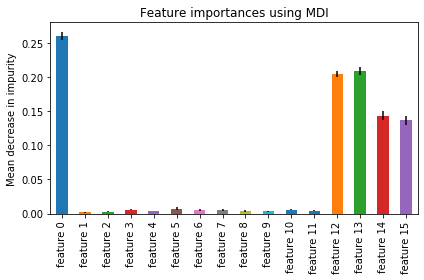

KeyboardInterrupt: 

In [17]:
# RANDOM FOREST
model = RandomForestClassifier(n_estimators=15) # n=30 only a few % better than n=4
clf = model.fit(X_train, y_train)
y_predict=clf.predict(X_test)

# analyze fit
cm=confusion_matrix(y_test, y_predict >= 0.5)
print(cm/float(len(y_test)))
print(classification_report(y_test,y_predict >= 0.5))

# feature importance based on impurity
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()


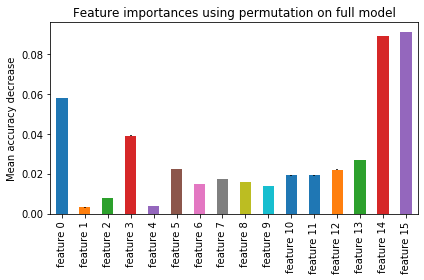

In [21]:
# based on permutation
model_fi = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)
forest_importances = pd.Series(model_fi.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=model_fi.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()